In [1]:
import os
import astropy.io.ascii as at
from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
import astropy.units as u
import astropy.units.cds as cds

from astropy.time import Time
import schwimmbad
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir = "."
def get_data(name,to_delete=None):
    ccf_sum_file = os.path.join(data_dir,"{0}.ccfSum.txt".format(name))
    vzero_file = os.path.join(data_dir,"{0}.vzero.txt".format(name))
    #ccf_sum_file = os.path.join(data_dir,"{0}/{0}.ccfSum.txt".format(name))
    #vzero_file = os.path.join(data_dir,"{0}/{0}.vzero.txt".format(name))
    print(data_dir)
    print(vzero_file)

    if os.path.exists(vzero_file):
        print("using Vzero corrected file")
        vzeros = at.read(vzero_file)
        t_raw = vzeros["col1"]*cds.JD
        rv = vzeros["col2"]/1000*u.km/u.s
        rve = vzeros["col3"]/1000*u.km/u.s
        #if abs(rv[0])<0.05:
        #    is_vzero[i] = True
    elif os.path.exists(ccf_sum_file):
        print("Using relative RVs")
        ccfs = at.read(ccf_sum_file)
#        print(ccfs)
#        if np.any(";" in ccfs["BJD_UTC"]):
#             for i in len(ccfs):
        if (type(ccfs["BJD_UTC"][0])!=np.float64) and (";" in ccfs["BJD_UTC"][0]):
            # Sam has informed me that the ; is a comment!
            ccfs = ccfs[1:]
        t_raw = np.asarray(ccfs["BJD_UTC"],dtype=np.float64)*cds.JD
        rv = np.asarray(ccfs["rv"],dtype=np.float64)/1000*u.km/u.s
        rve = np.asarray(ccfs["rv_err"],dtype=np.float64)/1000*u.km/u.s
    else:
        return None
    
    
    # Set up the RV Data object
    t_day = t_raw.to(u.day)
    t = t_day.value
    data = RVData(t=t, rv=rv, stddev=rve)
    return data
    

In [3]:
data = get_data("CB0228")

.
./CB0228.vzero.txt
using Vzero corrected file


In [4]:
#OK. So what the Joker thinks is MJD is actually JD
print("'MJD'",data.t.mjd)
#So when it tries to convert to JD...it's just wrong
print("'JD'",data.t.jd)
#Is this an input problem or a Joker problem?

'MJD' [2458602.790226 2458621.688666 2458631.722543]
'JD' [4858603.290226 4858622.188666 4858632.222543]


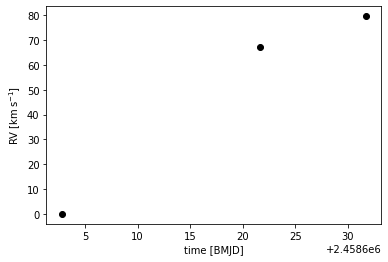

In [5]:
ax = data.plot()

In [6]:
params = JokerParams(P_min=8*u.day, P_max=4096*u.day)

In [7]:
joker = TheJoker(params)
samples = joker.rejection_sample(data, n_prior_samples=int(2**20)) # doctest: +SKIP

INFO: 171 good samples after rejection sampling [thejoker.sampler.sampler]


2458602.790226 2458848.9583333335


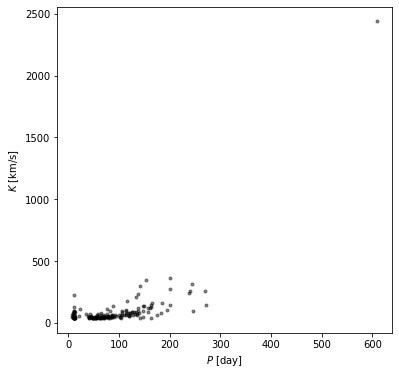

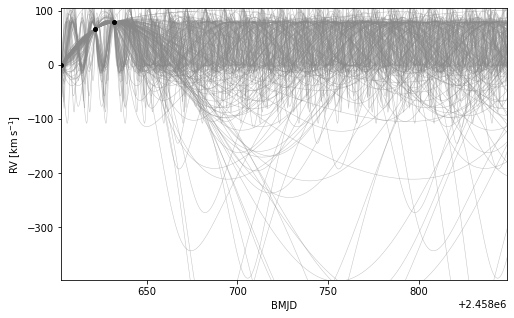

In [8]:
run_end = Time("2019-12-31T11:00:00")

fig, ax = plt.subplots(1, 1, figsize=(6,6)) # doctest: +SKIP
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,
           marker='.', color='k', alpha=0.45) # doctest: +SKIP
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")
# ax.set_xlim(-5, 128)
# ax.set_ylim(0.75, 3.)

# ax.scatter(61.942, 1.3959, marker='o', color='#31a354', zorder=-100)

fig, ax = plt.subplots(1, 1, figsize=(8,5)) # doctest: +SKIP
print(min(data.t.mjd),run_end.jd)
t_grid = np.linspace(min(data.t.mjd),run_end.jd, 1024)
_ = plot_rv_curves(samples, t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888',alpha=0.5))
# ax.set_xlim(min(data.t.mjd)-1, max(data.t.mjd)+1)

# Add Astroplan

In [9]:
from astropy.coordinates import SkyCoord
from astroplan import FixedTarget


In [10]:
coma = FixedTarget(coord=SkyCoord(ra=187.158916666667*u.deg, 
                                  dec=26.2269083333333*u.deg), 
                   name="CB0228")


In [11]:
from astroplan import Observer
observer = Observer.at_site('flwo')

In [51]:
time_range = Time(["2019-12-01 06:00", "2019-12-19 18:00"])

In [52]:
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint,MoonSeparationConstraint)
from astroplan.utils import time_grid_from_range
from astroplan import is_observable, is_always_observable, months_observable

In [53]:
from astroplan import Constraint, is_observable, min_best_rescale
from astropy.coordinates import Angle
import astropy.units as u

class RVDispersionConstraint(Constraint):
    """
    Observe the star when the dispersion in possible orbits is highest.
    """
    def __init__(self, samples, min=None, max=None,rv_unit=u.km/u.s, 
                 max_samp=200,boolean_constraint=True
                 ):
        """
        samples: samples output by TheJoker
    
        min : `~astropy.units.Quantity` or `None` (optional)
            Minimum acceptable model dispersion for observation. `None`
            indicates no limit.
        max : `~astropy.units.Quantity` or `None` (optional)
            Maximum acceptable model dispersion for observation. `None`
            indicates no limit.
        """
        if len(samples)>max_samp:
            self.samples = samples[:max_samp]
        else:
            self.samples = samples
            
        self.rv_unit = rv_unit
        self.n_samp = len(samples)

        self.min = min if min is not None else 0.5*self.rv_unit
        self.max = max if max is not None else 1000*self.rv_unit
        self.boolean_constraint = boolean_constraint

    def compute_constraint(self, times, observer=None, targets=None,
                           return_disp=False):
        """
        times: astropy Time grid
        
        """
        
        model_rv = np.zeros((self.n_samp, len(times)))
        for i in range(self.n_samp):
            orbit = self.samples.get_orbit(i)
            model_rv[i] = orbit.radial_velocity(times).to(self.rv_unit).value
        
        model_dispersion = abs(np.percentile(model_rv,99.9,axis=0) - 
                       np.percentile(model_rv,0.1,axis=0))*self.rv_unit

        min_disp = np.percentile(model_dispersion,50)*self.rv_unit

        if return_disp:
            return model_dispersion
        elif self.boolean_constraint:
#             print(self.min)
#             print(model_dispersion)
            mask = ((min_disp < model_dispersion))
            return mask

        # if we want to return a non-boolean score
        else:
            # rescale the vega_separation values so that they become
            # scores between zero and one
            min_disp = np.percentile(model_disperion,50)
            rescale = min_best_rescale(model_dispersion, min_disp,
                                       self.max, less_than_min=0)
            return rescale

In [54]:
constraints = [AltitudeConstraint(40*u.deg, 90*u.deg),
               AirmassConstraint(2), 
               AtNightConstraint.twilight_astronomical(),
               RVDispersionConstraint(samples,50*u.km/u.s, 700*u.km/u.s)]

In [55]:
# Are targets *ever* observable in the time range?
ever_observable = is_observable(constraints, observer, [coma], time_range=time_range)

# Are targets *always* observable in the time range?
always_observable = is_always_observable(constraints, observer, [coma],  time_range=time_range)

# During what months are the targets ever observable?
best_months = months_observable(constraints, observer, [coma])

In [56]:
print(ever_observable, always_observable, best_months)

[ True] [False] [{4, 5, 6, 7}]


In [57]:
time_grid = time_grid_from_range(time_range,
                                 time_resolution=8*u.hour)

In [58]:
observability_grid = np.zeros((len(constraints), len(time_grid)))

for i, constraint in enumerate(constraints):
    # Evaluate each constraint
    observability_grid[i, :] = constraint(observer, coma, times=time_grid)


In [61]:
time_grid[0].datetime

datetime.datetime(2019, 12, 1, 6, 0)

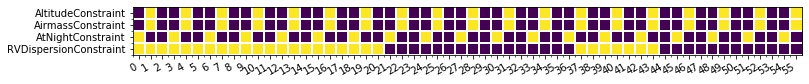

In [59]:

# Create plot showing observability of the target:

extent = [-0.5, -0.5+len(time_grid), -0.5, 3.5]

fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(observability_grid, extent=extent)

ax.set_yticks(range(0, len(constraints))[::-1])
ax.set_yticklabels([c.__class__.__name__ for c in constraints])

ax.set_xticks(range(len(time_grid)))
ax.set_xticklabels([t.datetime.
                    
#                     strftime("%H:%M") for t in time_grid])

ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)

ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.tick_params(axis='x', which='minor', bottom='off')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

ax.tick_params(axis='y', which='minor', left='off')
# ax.set_xlabel('Time on {0} UTC'.format(time_grid[0].datetime.date()))
# fig.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.1)
# plt.show()

2458602.790226 2458848.9583333335
2458830.75 2458837.1666666786


(-1800, 500)

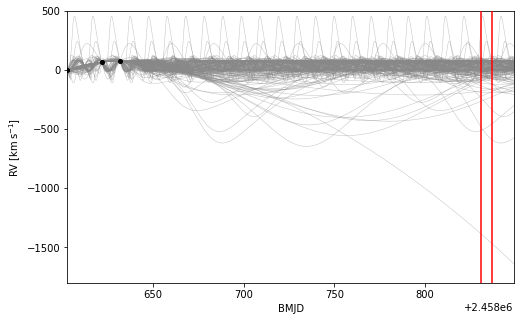

In [44]:

fig, ax = plt.subplots(1, 1, figsize=(8,5)) # doctest: +SKIP
print(min(data.t.mjd),run_end.jd)
t_grid = np.linspace(min(data.t.mjd),run_end.jd, 1024)
_ = plot_rv_curves(samples, t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888',alpha=0.5))
print(time_grid[0].jd,time_grid[-1].jd)
ax = plt.gca()
ax.axvline(time_grid[0].jd,zorder=100,alpha=1,color="r")
ax.axvline(time_grid[-1].jd,zorder=100,alpha=1,color="r")
plt.ylim(-1800,500)

In [45]:
mod_disp = constraints[-1].compute_constraint(time_grid,return_disp=True)

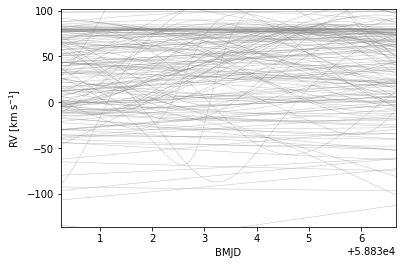

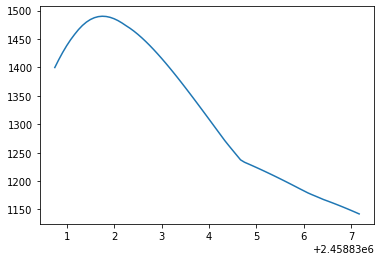

In [46]:

fig, ax = plt.subplots(1, 1)
_ = plot_rv_curves(samples, time_grid, rv_unit=u.km/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888',alpha=0.5))

plt.figure()
plt.plot(time_grid.jd,mod_disp)


In [24]:
n_samp=len(samples)
rv_unit=u.km/u.s
times=time_grid
model_rv = np.zeros((n_samp, len(times)))
for i in range(n_samp):
    orbit = samples.get_orbit(i)
    model_rv[i] = orbit.radial_velocity(times).to(rv_unit).value
# for i,t in enumerate(times):
#     print(np.nanmin(model_rv[:,i]),np.nanmax(model_rv[:,i]))

print(model_rv.shape,n_samp,len(times))
model_dispersion1 = model_rv.std(axis=0)*rv_unit

model_dispersion2 = abs(np.percentile(model_rv,99.9,axis=0) - 
                       np.percentile(model_rv,0.1,axis=0))


model_dispersion3 = abs(np.percentile(model_rv,99,axis=0) - 
                       np.percentile(model_rv,1,axis=0))


(171, 78) 171 78


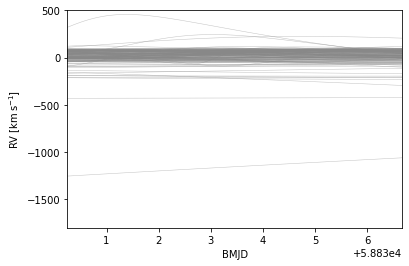

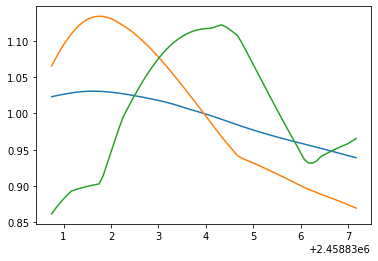

In [25]:
fig, ax = plt.subplots(1, 1)
_ = plot_rv_curves(samples, time_grid, rv_unit=u.km/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888',alpha=0.5))
plt.ylim(-1800,500)

plt.figure()
plt.plot(time_grid.jd,model_dispersion1/np.median(model_dispersion1))
plt.plot(time_grid.jd,model_dispersion2/np.median(model_dispersion2))
plt.plot(time_grid.jd,model_dispersion3/np.median(model_dispersion3))